# N-Body Problem

In [15]:
# interative 3d plot
%matplotlib widget
import numpy as np # vector calculations
import plot_util # plotting functions
from scipy.constants import G  # Gravitational constant

## Euler's Method

### Equation of Motions
#### let:
* $r_i(t)$ - position of body in 3D
* $v_i(t)$ - velocity
* $m_1$ - mass
* $F_{i \to j}$ - force of body $i$ due to body $j$

### Newtonian Gravity
$m_{i}\frac{d^2\mathbf{r_i}}{dt}=\sum_{j=1}^{N}F_{i \to j}$ , where $F_{j \to k}=-\frac{Gm_im_j}{\parallel\mathbf{r_i}-\mathbf{r_j}\parallel^3}(\mathbf{r_i}-\mathbf{r_j})$


In [16]:
def compute_force(r_i, r_j, m_i, m_j):
    result_vector = np.subtract(r_i, r_j) # Distance between vectors
    magnitude = np.linalg.norm(result_vector) # Magnitude of vector

    if magnitude == 0:
        return np.zeros(3) # Avoid division by 0

    # Newtonian gravity
    force = ((-1 *G * m_i * m_j) / (magnitude ** 3)) * result_vector

    return force

In [17]:
# Example: Force of body i due to body j
r_i = np.array([1.0, 2.0, 0.0])
r_j = np.array([3.0, 5.0, 0.0])

# Example masses
m_i = 5.0
m_j = 10.0

# Compute force
force_ij = compute_force(r_i, r_j, m_i, m_j)
print("Force on i due to j:", force_ij)

Force on i due to j: [ 1.42393674e-10  2.13590511e-10 -0.00000000e+00]


In [18]:
def compute_net_force(i, positions, masses):

    N = len(masses) # Number of bodies
    net_force = np.zeros(3)
    
    for j in range(N):
        if j != i: # exclude self exerted force
            force_ij = compute_force(positions[i], positions[j], masses[i], masses[j])
            net_force += force_ij  # Sum all forces acting on body i
        
    return net_force

In [19]:
# Example: 3 bodies in 3D space
positions = np.array([
    [1.0, 2.0, 0.0],  # Body 0
    [3.0, 5.0, 0.0],  # Body 1
    [-2.0, -1.0, 0.0] # Body 2
])
masses = np.array([5.0, 10.0, 15.0])  # Masses of 3 bodies

# Compute net force on body 0
net_force_0 = compute_net_force(0, positions, masses)
print("Net force on body 0:", net_force_0)

Net force on body 0: [-5.42497757e-11  1.69470612e-11  0.00000000e+00]


### First order conversion
* $\frac{d\mathbf{r_i}}{dt}=\mathbf{v_i}$
* $\frac{d\mathbf{v_i}}{dt}=\frac{1}{m_1}\sum_{j\neq{i}}^{N}F_{j\to i}$

### Method in vector form steps forword from time $t_n$ to $t_{n+1} = t_n + h $
$\mathbf{r_i}(t_{n+1})=\mathbf{r_i}(t_n)+h\mathbf{h_I}(t_n)$  
$\mathbf{v_i}(t_{n+1})=\mathbf{v_i}(t_n)+h\mathbf{a_i}(t_n)$  
where $ \mathbf{a_i}(t_{n})=\frac{d\mathbf{v_i}}{dt}\Big|_{t_n}=m_{i}=\sum_{j\neq{i}}^{N}F_{i \to j}$

In [20]:
def euler_update(positions, velocities, masses, h):
    N = len(masses)  # Number of bodies
    
    # Create temporary arrays to store updates
    new_positions = np.copy(positions)
    new_velocities = np.copy(velocities)

    # Compute net forces for all bodies first (before updating any values)
    forces = np.array([compute_net_force(i, positions, masses) for i in range(N)])

    # Apply Euler's method updates
    for i in range(N):
        a_i = forces[i] / masses[i]  # Compute acceleration

        # Update velocity and position
        new_positions[i] = positions[i] + h * velocities[i]
        new_velocities[i] = velocities[i] + h * a_i

    # Update original arrays safely
    positions[:] = new_positions  # Ensures in-place modification
    velocities[:] = new_velocities  # Ensures in-place modification

In [21]:
def simulate(N, bodies, timesteps, h, method="euler"):
    positions = bodies[0].copy()
    velocities = bodies[1].copy()
    masses = bodies[2].copy()

    # Total bodies - selected # of bodies, same row/column between history & position arrays
    x = len(positions) - N
    
    # Store trajectory for visualization
    history = np.zeros((timesteps, N + x, 3)) # 3 refers to dimensions of position
    
    # Time-Stepping Loop
    for t in range(timesteps):
        history[t] = positions.copy() # Store positions at this timestep
        if method == "euler":
            euler_update(positions, velocities, masses, h)
        elif method == "rk4":
            RK4_update(positions, velocities, masses, h)
    
    return history

### Example - Solar System

This simulation uses real planetary mass, velocity, and position data to ensure accurate orbital trajectories. 

- The plot displays only the inner planets (Mercury through Mars) for better visualization.
- However, all nine planets (including gas giants) are included in calculations to improve orbital accuracy.
- The gravitational influence of Jupiter and beyond is crucial for correctly modeling the inner planets' orbits.


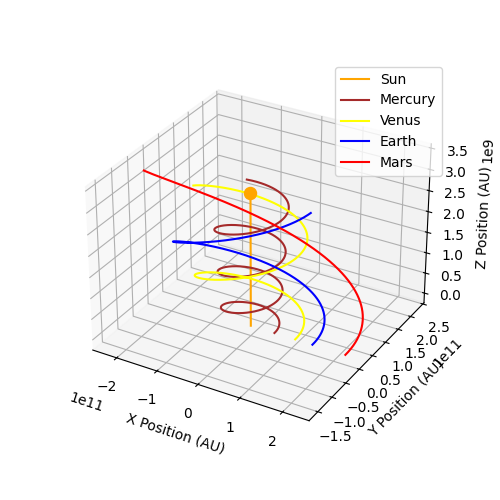

In [22]:
from bodies_util import solar_sys_positions, solar_sys_velocities, solar_sys_masses, solar_sys_attr

# Constant variables
N = 9 # Number of bodies calculated
N_plot = 5 # Number of bodies plotted
years = 1  # Earth years - less accurate as time increases (e.g. 5 years)
h = 1e4 # Time step size (seconds)
timesteps = int(years * 31557600 / h)  # Number of simulation steps

# Pre-set solar system data
bodies_1 = [solar_sys_positions, solar_sys_velocities, solar_sys_masses]

# Run Simulation
history_1 = simulate(N, bodies_1, timesteps, h)

plot_util.plot_solar_sys(history_1, N_plot, solar_sys_attr)

### Why Euler's Method is Bad for the N-Body Problem

The **Euler method** is the simplest numerical method for solving differential equations. It is not well-suited for solving the N-body problem. This is because it's a first-order method, meaning its error per step is $O(h^2)$ and its total accumulated error over time is $O(h)$. This leads to large inaccuracies, especially for long simulations.

Since gravitational forces vary significantly depending on distance $(F\sim\frac{1}{r^2})$, small errors in position cause large force errors like found in the Moon-Earth obrit compare to Earth-Sun.

Euler’s method requires an extremely small time step (\(h\)) in order to get higher accuracy. This makes it computationally expensive and inefficient for realistic simulations.

  
#### Better Alternatives for the N-Body Problem  
**Runge-Kutta (RK4)** – More accurate and widely used  
**Verlet Integration** – Good for physics simulations, used in molecular dynamics   
**Leapfrog Method** – Symplectic and conserves energy well  

**Conclusion**: Euler’s method is too inaccurate and unstable for long-term N-body simulations!


## Runge–Kutta methods

### Equations
Given initial value:
$$y_{n+1}=y_n+\frac{h}{6}(k_1+2k_1+2k_3+k_4)$$   
where:  
$$k_1=f(t_n,y_n)$$ 
$$k_2=f(t_n+\frac{h}{2},y_n+\frac{h}{2}k_1)$$
$$k_3=f(t_n+\frac{h}{2},y_n+\frac{h}{2}k_2)$$  
$$k_4=f(t_n+h,y_n+hk_3)$$


In [23]:
def compute_accelerations(positions, masses):
    N = len(masses)
    accelerations = np.zeros_like(positions)  # shape (N, 3)

    for i in range(N):
        net_force = compute_net_force(i, positions, masses)
    
        # a_i = F_i / m_i
        accelerations[i] = net_force / masses[i]
    return accelerations

In [24]:
def RK4_update(positions, velocities, masses, h):
    # k1
    a1 = compute_accelerations(positions, masses)  # depends only on positions for gravity
    k1_r = velocities
    k1_v = a1
    
    # k1
    positions_half = positions + 0.5 * h * k1_r
    velocities_half = velocities + 0.5 * h * k1_v
    a2 = compute_accelerations(positions_half, masses)
    k2_r = velocities_half
    k2_v = a2
    
    # k3
    positions_half2 = positions + 0.5 * h * k2_r
    velocities_half2 = velocities + 0.5 * h * k2_v
    a3 = compute_accelerations(positions_half2, masses)
    k3_r = velocities_half2
    k3_v = a3
    
    # k4
    positions_end = positions + h * k3_r
    velocities_end = velocities + h * k3_v
    a4 = compute_accelerations(positions_end, masses)
    k4_r = velocities_end
    k4_v = a4
    
    # Update positions and velocities (standard RK4)
    positions[:] = positions + (h /6.0) * (k1_r + 2 * k2_r + 2 * k3_r + k4_r)
    velocities[:] = velocities + (h /6.0) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)

### Example - Solar System Pt. 2

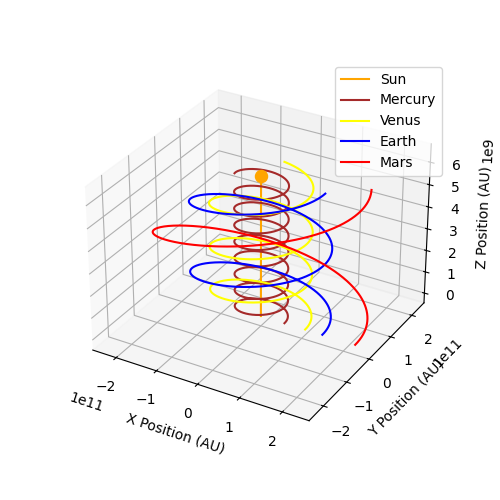

In [25]:
from bodies_util import solar_sys_positions, solar_sys_velocities, solar_sys_masses, solar_sys_attr

# Constant variables
N = 9 # Number of bodies calculated
N_plot = 5 # Number of bodies plotted
years = 2 # Earth years
h = 1e4 # Time step size (seconds)
timesteps = int(years * 31557600 / h)  # Number of simulation steps

# Pre-set solar system data
bodies_2 = [solar_sys_positions, solar_sys_velocities, solar_sys_masses]

# Run Simulation
history_2 = simulate(N, bodies_2, timesteps, h, method="rk4")

plot_util.plot_solar_sys(history_2, N_plot, solar_sys_attr)

### Example - Figure-8 (3 Body)

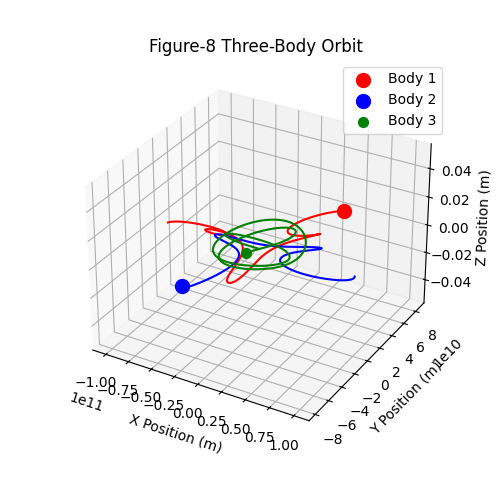

In [26]:
from bodies_util import fig8_masses, fig8_positions, fig8_velocities

# Constant variables
N = 3 # Number of bodies 
years = 0.5 # **best time duration for this simulation**
h = 1e3  # **best time step size (seconds) for this simulation**
timesteps = int(years * 31557600 / h)

# Pre-set figure-8 data
bodies_3 = [fig8_positions, fig8_velocities, fig8_masses]

# Run Simulation
history_3 = simulate(N, bodies_3, timesteps, h, method="rk4")

plot_util.plot_fig8(history_3)

### Why Runge-Kutta 4 (RK4) is Better for the N-Body Problem

The **Runge-Kutta 4th Order Method (RK4)** is a numerical method for solving differential equations with significantly higher accuracy than Euler’s method. It is a fourth-order method, meaning its error per step is $O(h^5)$, and its total accumulated error is $O(h^4)$. This makes it much more precise for long-term simulations like the N-body problem.

Instead of using just one slope like Euler's method, RK4 computes four slope estimates at different points within a time step and averages them in a weighted manner to produce a highly accurate next value. This makes RK4 far more stable and less prone to energy drift.

Since gravitational forces vary significantly depending on distance $(F \sim \frac{1}{r^2})$, RK4 helps reduce errors that would otherwise grow uncontrollably, like those found in the Moon-Earth orbit compared to the Earth-Sun system.

This method significantly reduces truncation errors and maintains stability over long simulations.


**Conclusion**: RK4 provides a major improvement over Euler’s method by reducing numerical errors and maintaining long-term stability, making it one of the best choices for solving the N-body problem!
